In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [2]:
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)


In [3]:
N = 512
datadir = '/global/cscratch1/sd/tmedan/notebooks/'


In [4]:

class ScaleField(): 
    # used min-max scaling HERE ONLY 
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max() 
        self.fmean = field.mean()
    
    def scale(self, field, inv=False): 
        if not inv:
            self.scaled = True
            return (field - self.fmin) / (self.fmax - self.fmin)
        if inv:
            self.scaled = False
            return field * (self.fmax - self.fmin) + self.fmin


In [5]:
img_shape = 32
def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [6]:
def down_conv(n_filters):
    return tfk.Sequential([
        tfkl.Conv3D(n_filters, kernel_size = (4,4,4) , strides=(2,2,2),
                    padding='same'),
        tfkl.LeakyReLU()])  

def up_conv(n_filters):
    return tfk.Sequential([
        tfkl.Conv3DTranspose(n_filters, kernel_size = (4,4,4), strides = (2,2,2), 
                         padding='same'),
        tfkl.ReLU()])




class UNet(tfk.Model):

    def __init__(self):
        super(UNet,self).__init__()
        self.conv_down1 = down_conv(4)
        self.conv_down2 = down_conv(8)
        self.conv_down3 = down_conv(16)
        
        self.conv_up3 = up_conv(32)
        self.conv_up2 = up_conv(64)
        self.conv_last = tfkl.Conv3DTranspose(64, kernel_size=(4,4,4), strides=(2,2,2), 
                                              padding='same')
        
        
    def call(self,input):
        conv1 = self.conv_down1(input) 
        conv2 = self.conv_down2(conv1)
        conv3 = self.conv_down3(conv2) 
 
        
    
        x = self.conv_up3(conv3) 
        x = self.conv_up2(x)
        x = self.conv_last(x)
        out = tfkl.Activation('relu')(x)
        return out
    



In [7]:
model = UNet()



In [8]:
model.build(input_shape=(None, img_shape,img_shape,img_shape, 1))
optimizer = tfk.optimizers.Adam(1e-3)

model.compile(loss='mse',
             optimizer=optimizer,
             metrics=['mae'])
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  260       
_________________________________________________________________
sequential_1 (Sequential)    multiple                  2056      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  8208      
_________________________________________________________________
sequential_3 (Sequential)    multiple                  32800     
_________________________________________________________________
sequential_4 (Sequential)    multiple                  131136    
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr multiple                  262208    
Total params: 436,668
Trainable params: 436,668
Non-trainable params: 0
_______________________________________________________

In [9]:
#training data

def data_feeder(n_files, img_shape):
    sim_size  =  512
    n_subcube = int((sim_size//img_shape)**3)
    # make empty array first.
    densE = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    densL = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    reion = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    for i in range(n_files):
        # load in simulation
        densEfile_i = datadir+'density_Eul/dens_{:02d}'.format(i)
        densE_i = np.fromfile(open(densEfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        
        densLfile_i = datadir+'density_Lag/dens_{:02d}'.format(i)
        densL_i = np.fromfile(open(densLfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        
        reionfile_i = datadir+'reionization/reion_{:02d}'.format(i)
        reion_i = np.fromfile(open(reionfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        #reshape to subcubes
        densE[i] = cubify(densE_i,(img_shape,img_shape,img_shape))
        densL[i] = cubify(densL_i,(img_shape,img_shape,img_shape))
        reion[i] = cubify(reion_i,(img_shape,img_shape,img_shape))
    # add additional axis for number of channels
    densE = densE[..., np.newaxis]
    densL = densL[..., np.newaxis]
    reion = reion[..., np.newaxis]
    # scale all fields at once
    densE = ScaleField(densE).scale(field=densE)
    densL = ScaleField(densL).scale(field=densL)
    reion = ScaleField(reion).scale(field=reion)
    return densE,densL,reion

data = data_feeder(1,32)
densE_train = data[0]
densL_train = data[1]
reion_train = data[2]

In [14]:
# get test data

freion = open(datadir+'reionization/reion_05')
fdens  = open(datadir+'density_Eul/dens_05')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


x_test = ScaleField(x_test).scale(field=x_test)
y_test = ScaleField(y_test).scale(field=y_test)


# plt.figure(figsize=(10,10))
# plt.imshow(x_test[0])
# plt.colorbar()

# plt.figure(figsize=(10,10))
# plt.imshow(y_test[0])
# plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]

print(x_test.shape)

reion_test  = ScaleField(y_test).scale(field=y_test,inv=True)

(4096, 32, 32, 32, 1)


In [10]:
for i in range(densE_train.shape[0]):
    history = model.fit(densE_train[i],reion_train[i],
                    epochs=2,
                    validation_split=0.1)
    
'''submit for one hour
use cori gpu submission 
through srun
'''

Epoch 1/2
116/116 [==============================] - 15s 131ms/step - loss: 0.0165 - mae: 0.0859 - val_loss: 0.0111 - val_mae: 0.0711
Epoch 2/2
116/116 [==============================] - 14s 124ms/step - loss: 0.0083 - mae: 0.0546 - val_loss: 0.0075 - val_mae: 0.0493


'submit for one hour\nuse cori gpu submission \nthrough srun\n'

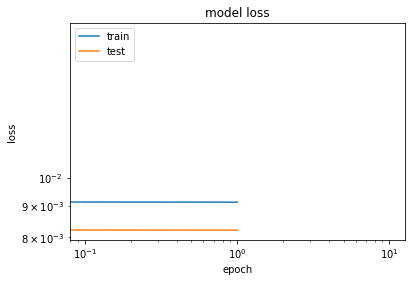

In [24]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.xscale('log')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('true_v-net')
plt.show()

In [17]:
#model.save('true_v-net')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Resnet50/assets


In [16]:
y_test_predict = model.predict(x_test,batch_size=52)

reion_test_predict = ScaleField(y_test_predict).scale(field = y_test_predict, inv=True)

ResourceExhaustedError:  OOM when allocating tensor with shape[52,64,16,16,16] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node u_net/conv3d_transpose_2/conv3d_transpose (defined at <ipython-input-6-98fdb9032d32>:62) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_3054]

Errors may have originated from an input operation.
Input Source operations connected to node u_net/conv3d_transpose_2/conv3d_transpose:
 u_net/sequential_4/re_lu_1/Relu (defined at <ipython-input-6-98fdb9032d32>:61)

Function call stack:
predict_function


In [12]:
yshow_predict = reion_test_predict[0,img_shape//2, ..., 0]
yshow = reion_test[0,img_shape//2, ..., 0]
xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

In [ ]:
plt.scatter(yshow.flatten(),yshow_predict.flatten(),c='k',s=0.5)
xx = np.linspace(yshow.min(), yshow.max(), 100)
plt.plot(xx,xx, 'k')

In [ ]:
plt.figure()
plt.imshow(yshow_predict, vmin = ymin, vmax=ymax)
plt.colorbar()
plt.title('V-Net Prediction')
plt.savefig('V-Net_predict')

plt.figure()
plt.imshow(yshow, vmin = ymin, vmax=ymax)
plt.colorbar()
plt.title('Actual 21CM Run')
plt.savefig('V-Net_actual')

diff = yshow_predict-yshow
plt.figure()
plt.imshow(diff, vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), cmap=plt.get_cmap('coolwarm'))
plt.colorbar()
plt.title('V-Net Difference')
plt.savefig('V-Net_diff')
